# scratch notebook for trying out Huggingface models

### mambavision
- https://huggingface.co/nvidia/MambaVision-T-1K
- https://arxiv.org/pdf/2407.08083

In [1]:
! module load cuda/12.2.0

In [53]:
# ! nvcc --version

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from transformers import AutoModel
from PIL import Image
from timm.data.transforms_factory import create_transform
import requests
from IPython.display import display
from natsort import natsorted
import skimage as ski
import numpy as np
import scanpy as sc
import os

In [56]:
model = AutoModel.from_pretrained("nvidia/MambaVision-T-1K", trust_remote_code=True)

# eval mode for inference
model.cuda().eval()

MambaVisionModel(
  (model): MambaVision(
    (patch_embed): PatchEmbed(
      (proj): Identity()
      (conv_down): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (levels): ModuleList(
      (0): MambaVisionLayer(
        (blocks): ModuleList(
          (0): ConvBlock(
            (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): GELU(approximate='tanh')
            (conv2): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm

In [57]:
# prepare image for the model
# url = 'http://images.cocodataset.org/val2017/000000020247.jpg'
# image = Image.open(requests.get(url, stream=True).raw)
# input_resolution = (3, 224, 224)  # MambaVision supports any input resolutions

image = Image.open("../votj_aligned_images_align_any/PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_E04.tif-aligned.tif")
input_resolution = (len(image.split()), image.size[0], image.size[1])
print(input_resolution)

transform = create_transform(input_size=input_resolution,
                             is_training=False,
                             mean=model.config.mean,
                             std=model.config.std,
                             crop_mode=model.config.crop_mode,
                             crop_pct=model.config.crop_pct)

print(transform)

inputs = transform(image).unsqueeze(0).cuda()

(3, 1702, 1702)
Compose(
    Resize(size=1702, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(1702, 1702))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


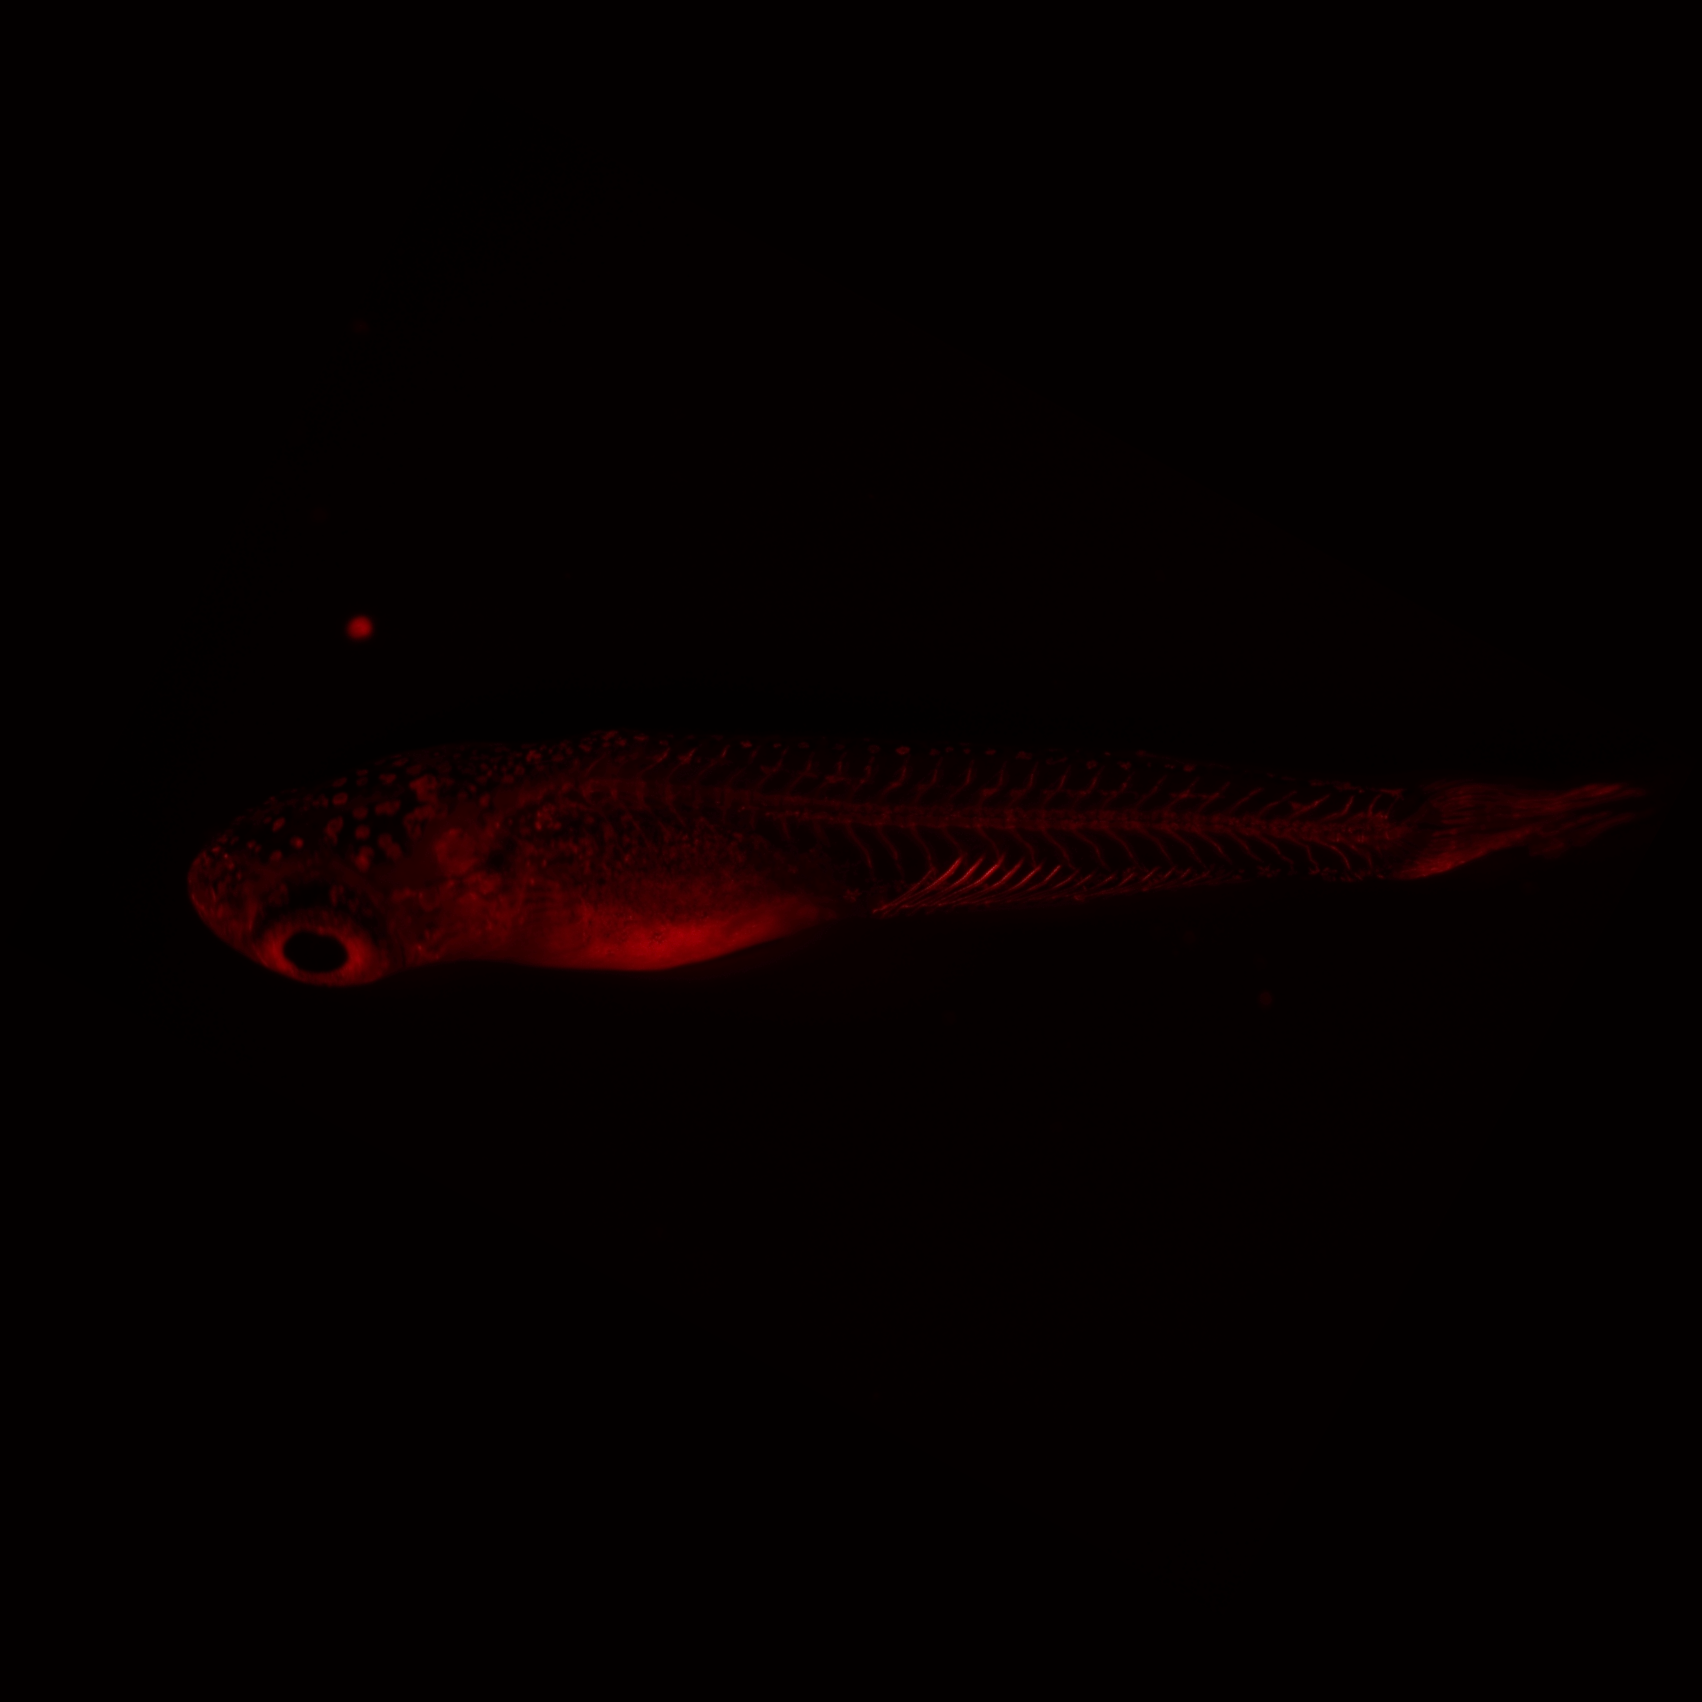

In [58]:
image.show()
display(image)

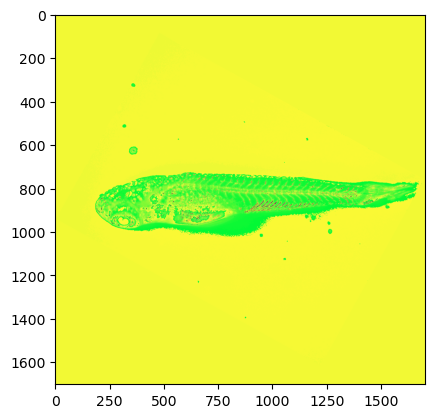

(1702, 1702)


In [59]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

image_t = TF.to_pil_image(transform(image))
plt.imshow(image_t)
plt.show()

print(image_t.size)

In [60]:
# model inference
out_avg_pool, features = model(inputs)
print("Size of the averaged pool features:", out_avg_pool.size())  # torch.Size([1, 640])
print("Number of stages in extracted features:", len(features)) # 4 stages
print("Size of extracted features in stage 1:", features[0].size()) # torch.Size([1, 80, 56, 56])
print("Size of extracted features in stage 2:", features[1].size())
print("Size of extracted features in stage 3:", features[2].size())
print("Size of extracted features in stage 4:", features[3].size()) # torch.Size([1, 640, 7, 7])

Size of the averaged pool features: torch.Size([1, 640])
Number of stages in extracted features: 4
Size of extracted features in stage 1: torch.Size([1, 80, 426, 426])
Size of extracted features in stage 2: torch.Size([1, 160, 213, 213])
Size of extracted features in stage 3: torch.Size([1, 320, 107, 107])
Size of extracted features in stage 4: torch.Size([1, 640, 54, 54])


In [61]:
feature_matrix = []
counter = 0

input_path = '/nfs/research/birney/users/esther/medaka-img/votj_aligned_images_align_any'

for img_name in natsorted(os.listdir(path = input_path)):
    counter += 1
    img = Image.open(input_path + "/" + img_name)
    input_resolution = (len(img.split()), img.size[0], img.size[1])

    # img.show()
    # display(img)
    # print(input_resolution)

    inputs = transform(img).unsqueeze(0).cuda()
    
    # img_t = TF.to_pil_image(transform(img))
    # plt.imshow(img_t)
    # plt.show()

    out_avg_pool, features = model(inputs)
    
    feature_matrix.append(out_avg_pool.detach())
    if counter % 10 == 0:
        print(counter)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700


KeyboardInterrupt: 

In [ ]:
print(len(feature_matrix))

print(feature_matrix[0].size())

2353
torch.Size([1, 640])


In [ ]:
torch.save(feature_matrix, ('/nfs/research/birney/users/esther/medaka-img/features/huggingface_mambavision-t-1k_22092024.pt'))

Read in the feature matrix and output 

In [5]:
feature_list = torch.load('../features/huggingface_mambavision-t-1k_22092024.pt')
feature_matrix = np.array(([np.array(i.cpu()) for [i] in feature_list]))

# Create the AnnData object to calculate UMAP (ScanPy)
obs_names = [file.rsplit(".", 1)[0] for file in natsorted(os.listdir(path = '../flipped_transformed_images2/image/'))]

feature_matrix_anndata = sc.AnnData(X = feature_matrix)
feature_matrix_anndata.obs_names = obs_names

In [6]:
feature_matrix_anndata.write_csvs(dirname='../features/huggingface_mambavision-t-1k_22092024', 
                                  skip_data = False,
                                  sep=',')